<a href="https://colab.research.google.com/github/Laofin050/TemuKembaliCitra_2018-049_2018-050/blob/main/Aplikasi_Tugas_Besar_CBIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Aplikasi Tugas Besar CBIR**
**Feny Septhalia Insyira Putri- 201810370311049**

**Laofin Aripa - 20180370311050**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Definisikan path kaggle json
# Sesuaikan dengan path anda
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Tubes-TKC"

In [ ]:
# Ubah lokasi direktori kerja
# Sesuaikan dengan path anda
%cd /content/drive/MyDrive/Tubes-TKC

/content/drive/MyDrive/Tubes-TKC


In [ ]:
ls

kaggle.json


In [ ]:
%rm -rf logs/
%rm -rf chest_xray/

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:29<00:00, 14.7MB/s]
100% 2.29G/2.29G [00:29<00:00, 82.5MB/s]


In [ ]:
# Ekstrak file dataset dan hapus file zip dataset agar tidak memakan banyak tempat.
!unzip \*.zip &> /dev/null && rm *.zip

In [ ]:
!ls

chest_xray  kaggle.json


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
import numpy as np

In [ ]:
from os import mkdir

mkdir('/content/x-ray')
mkdir('/content/x-ray/NORMAL')
mkdir('/content/x-ray/PNEUMONIA')

In [ ]:
import os
import shutil

NORMAL_train = "/content/drive/MyDrive/Tubes-TKC/chest_xray/chest_xray/train/NORMAL"
NORMAL_new = "/content/x-ray/NORMAL"

files = os.listdir(NORMAL_train)

for file in files[0:int(len(files))]:
  new_path = shutil.move(f"{NORMAL_train}/{file}", NORMAL_new)

In [ ]:
import os
import shutil

NORMAL_test = "/content/drive/MyDrive/Tubes-TKC/chest_xray/chest_xray/test/NORMAL"
NORMAL_new = "/content/x-ray/NORMAL"

files = os.listdir(NORMAL_test)

for file in files[0:int(len(files))]:
  new_path = shutil.move(f"{NORMAL_test}/{file}", NORMAL_new)

In [ ]:
import os
import shutil

PNEUMONIA_train = "/content/drive/MyDrive/Tubes-TKC/chest_xray/chest_xray/train/PNEUMONIA"
PNEUMONIA_new = "/content/x-ray/PNEUMONIA"

files = os.listdir(PNEUMONIA_train)

for file in files[0:int(len(files))]:
  new_path = shutil.move(f"{PNEUMONIA_train}/{file}", PNEUMONIA_new)

In [ ]:
import os
import shutil

PNEUMONIA_test = "/content/drive/MyDrive/Tubes-TKC/chest_xray/chest_xray/test/PNEUMONIA"
PNEUMONIA_new = "/content/x-ray/PNEUMONIA"

files = os.listdir(PNEUMONIA_test)

for file in files[0:int(len(files))]:
  new_path = shutil.move(f"{PNEUMONIA_test}/{file}", PNEUMONIA_new)

In [ ]:
import numpy as np
import pandas as pd
import os
from shutil import copyfile

mkdir('/content/dataset')

TRAIN_DIR = "/content/dataset/train/"
VALID_DIR ="/content/dataset/valid/"
TEST_DIR ="/content/dataset/test/"

os.mkdir(TRAIN_DIR)
os.mkdir(VALID_DIR)
os.mkdir(TEST_DIR)

for label in ['NORMAL', 'PNEUMONIA']:
    os.mkdir(TRAIN_DIR+label)
    os.mkdir(VALID_DIR+label)
    os.mkdir(TEST_DIR+label)

# **Split Data**

In [ ]:
# TULIS KODE ANDA DISINI
import random

def train_valid_test_split(source, train_dir, valid_dir, test_dir,train_size, valid_size, test_size):
    # get files
    files = []
    for filename in os.listdir(source):
        file = source + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
    
    # train valid split

    train_size = int(len(files) * (1 - (valid_size + train_size)))
    valid_size = int(len(files)* (1 - (valid_size + test_size)))
    test_size = int(len(files)* (1 - train_size))
    
    # shuffle the dataset
    shuffled_files = random.sample(files, len(files))  

    train_set = shuffled_files[train_size:valid_size]
    valid_set = shuffled_files[valid_size:]
    test_set = shuffled_files[:train_size]
    
    for filename in train_set:
        filepath = source + filename
        destination = train_dir + filename
        copyfile(filepath, destination)
        
    for filename in valid_set:
        filepath = source + filename
        destination = valid_dir + filename
        copyfile(filepath, destination)
    
    for filename in test_set:
        filepath = source + filename
        destination = test_dir + filename
        copyfile(filepath, destination)

SOURCE = "/content/x-ray/"

for label in ['NORMAL', 'PNEUMONIA']:
    print(label)
    train_valid_test_split(SOURCE+label+'/', TRAIN_DIR +label+'/', VALID_DIR +label+'/', TEST_DIR +label+'/', train_size=0.8, valid_size=0.19, test_size=0.01)
    print(len(os.listdir(TRAIN_DIR +label+'/')))
    print(len(os.listdir(VALID_DIR +label+'/')))
    print(len(os.listdir(TEST_DIR +label+'/')))

NORMAL
1245
316
15
PNEUMONIA
3370
854
42


In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)
  

In [ ]:
train = get_training_data (TRAIN_DIR)
test = get_training_data (TEST_DIR)
val = get_training_data (VALID_DIR)

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



**Augmentasi Data**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   rescale=1./255,
                                   shear_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

training_set = train_datagen.flow_from_directory("/content/dataset/train/",
                                                 target_size=(64,64),
                                                 color_mode="rgb",
                                                 shuffle=False,
                                                 batch_size = 8,
                                                 class_mode='categorical')
val_datagen = ImageDataGenerator(width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        rescale=1./255,
                                        shear_range=0.2,
                                        horizontal_flip=True,
                                        fill_mode='nearest')

val_set = val_datagen.flow_from_directory("/content/dataset/valid/",
                                                        target_size=(64,64),
                                                        color_mode="rgb",
                                                        shuffle=False,
                                                        batch_size = 8,
                                                        class_mode='categorical')
test_datagen = ImageDataGenerator(width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        rescale=1./255,
                                        shear_range=0.2,
                                        horizontal_flip=True,
                                        fill_mode='nearest')

test_set = test_datagen.flow_from_directory("/content/dataset/test/",
                                                        target_size=(64,64),
                                                        color_mode="rgb",
                                                        shuffle=False,
                                                        batch_size = 8,
                                                        class_mode='categorical')

Found 4614 images belonging to 2 classes.
Found 1169 images belonging to 2 classes.
Found 57 images belonging to 2 classes.


Text(0.5, 1.0, 'NORMAL')

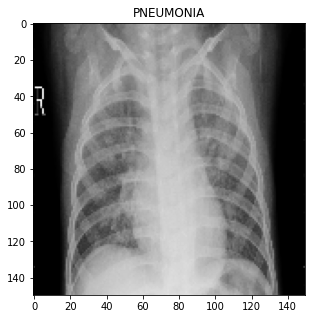

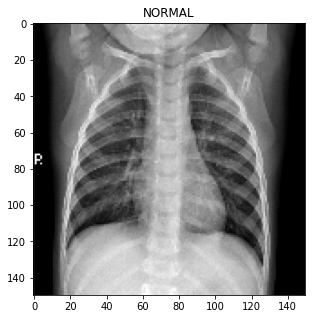

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [ ]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [ ]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [ ]:
# resize data 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range = 30,  
        zoom_range = 0.2, # 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip = True,  
        vertical_flip=False) 


datagen.fit(x_train)

**MODEL CNN**

In [ ]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_41 (Conv2D)          (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_29 (Bat  (None, 150, 150, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 dropout_24 (Dropout)        (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_30 (Bat  (None, 75, 75, 64)      

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.0001)

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,
                    epochs = 50 , 
                    validation_data = datagen.flow(x_val, y_val) ,
                    callbacks = [learning_rate_reduction])

Epoch 1/50
145/145 [==============================] - 18s 111ms/step - loss: 0.6742 - accuracy: 0.8104 - val_loss: 15.0551 - val_accuracy: 0.7305 - lr: 0.0010
Epoch 2/50
145/145 [==============================] - 16s 109ms/step - loss: 0.3108 - accuracy: 0.8849 - val_loss: 16.3784 - val_accuracy: 0.7305 - lr: 0.0010
Epoch 3/50
145/145 [==============================] - ETA: 0s - loss: 0.2830 - accuracy: 0.8971
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
145/145 [==============================] - 16s 109ms/step - loss: 0.2830 - accuracy: 0.8971 - val_loss: 7.4501 - val_accuracy: 0.7305 - lr: 0.0010
Epoch 4/50
145/145 [==============================] - 16s 110ms/step - loss: 0.1905 - accuracy: 0.9313 - val_loss: 4.1376 - val_accuracy: 0.7365 - lr: 3.0000e-04
Epoch 5/50
145/145 [==============================] - 16s 109ms/step - loss: 0.1713 - accuracy: 0.9410 - val_loss: 0.5053 - val_accuracy: 0.8674 - lr: 3.0000e-04
Epoch 6/50
145/145 [===============

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

2/2 [==============================] - 0s 28ms/step - loss: 0.2090 - accuracy: 0.9298
Loss of the model is -  0.2090199738740921
2/2 [==============================] - 0s 28ms/step - loss: 0.2090 - accuracy: 0.9298
Accuracy of the model is -  92.98245906829834 %


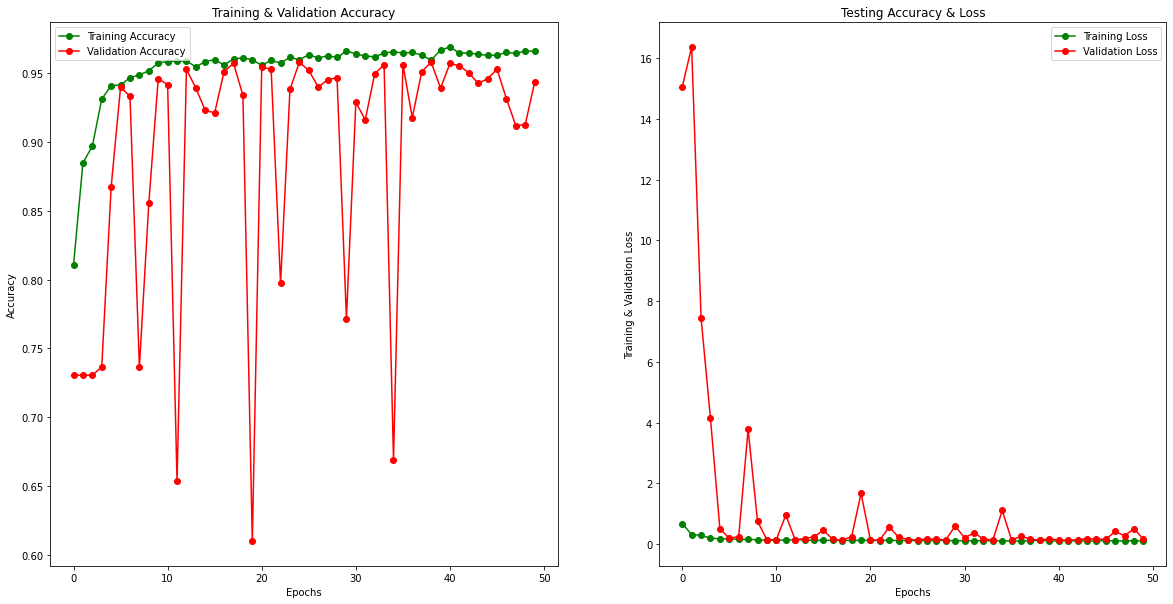

In [ ]:
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
predictions = (model.predict(x_test) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int32)

In [ ]:
cm = confusion_matrix(y_test,predictions)
cm

array([[39,  3],
       [ 1, 14]])

In [ ]:
import pandas as pd

cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

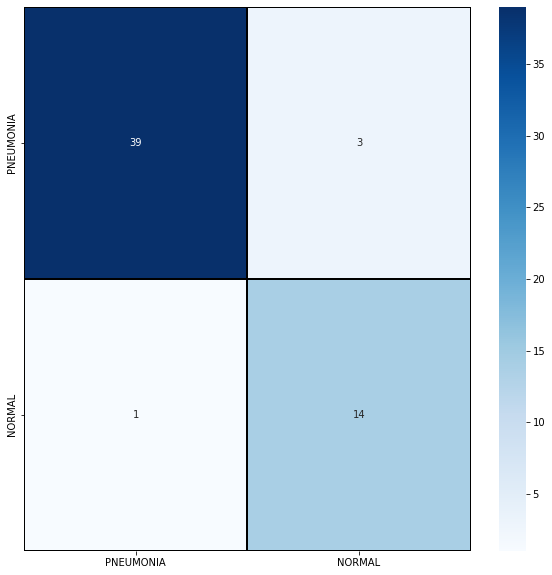

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [ ]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.97      0.93      0.95        42
   Normal (Class 1)       0.82      0.93      0.87        15

           accuracy                           0.93        57
          macro avg       0.90      0.93      0.91        57
       weighted avg       0.94      0.93      0.93        57

